<a href="https://colab.research.google.com/github/hyeminLee-project/used_book_grading/blob/main/faster_RCNN_20241020_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


경로 설정

In [ ]:
%cd /content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation

/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation


torch 및 torchvision 설치


In [ ]:
!pip install torch torchvision


COCO(Common Objects in Context) 데이터셋과 관련된 기능을 제공하는 라이브러리 설치


In [ ]:
!pip install pycocotools


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import os

# 학습에 사용할 장치 설정 (GPU 사용 가능 시 GPU로 설정)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로 설정
train_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/train"
annotation_file = os.path.join(train_data_path, "_annotations.coco.json")

# 데이터셋 로드
transform = T.Compose([T.ToTensor()])

try:
    train_dataset = CocoDetection(root=train_data_path, annFile=annotation_file, transform=transform)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# DataLoader 설정
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

# Faster R-CNN 모델 로드 및 수정 (num_classes = 10 + 1)
num_classes = 10 + 1  # 10개의 클래스 + 배경
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 기존의 ROI 헤드를 새로운 클래스 수에 맞게 수정
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 모델을 GPU/CPU로 이동
model.to(device)

# 옵티마이저 및 학습률 스케줄러 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # 매 50 에포크마다 학습률 감소

# 바운딩 박스 형식 변환 함수
def convert_bbox_format(box):
    """COCO 형식 [x, y, width, height] -> [x_min, y_min, x_max, y_max] 형식으로 변환"""
    x, y, w, h = box
    x_min = x
    y_min = y
    x_max = x + w
    y_max = y + h
    return [x_min, y_min, x_max, y_max]

# 학습 루프
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in train_loader:
        # 이미지와 타겟을 장치로 이동
        images = [image.to(device) for image in images]

        processed_targets = []
        for target_list in targets:
            boxes = []
            labels = []

            for ann in target_list:
                # 바운딩 박스 변환 및 유효성 검사
                converted_box = convert_bbox_format(ann["bbox"])
                if converted_box[2] > converted_box[0] and converted_box[3] > converted_box[1]:
                    boxes.append(torch.tensor(converted_box, dtype=torch.float32))
                    labels.append(ann["category_id"])

            if len(boxes) == 0:
                print(f"No valid boxes for image {target_list[0]['image_id']}, skipping.")
                continue

            image_id = torch.tensor(target_list[0]["image_id"], dtype=torch.int64)
            processed_target = {
                "boxes": torch.stack(boxes).to(device),
                "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                "image_id": image_id.to(device)
            }
            processed_targets.append(processed_target)

        optimizer.zero_grad()

        if len(processed_targets) == 0:
            print("No valid targets for this batch, skipping.")
            continue

        # 모델 예측 및 손실 계산
        loss_dict = model(images, processed_targets)

        # 개별 손실 출력
        cls_loss = loss_dict["loss_classifier"].item()
        box_loss = loss_dict["loss_box_reg"].item()
        rpn_cls_loss = loss_dict["loss_objectness"].item()
        rpn_box_loss = loss_dict["loss_rpn_box_reg"].item()

        print(f"cls_loss: {cls_loss:.4f}, box_loss: {box_loss:.4f}, "
              f"rpn_cls_loss: {rpn_cls_loss:.4f}, rpn_box_loss: {rpn_box_loss:.4f}")

        # 총 손실 계산 및 역전파
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {epoch_loss:.4f}")

# 학습된 모델 저장
torch.save(model.state_dict(), "faster_rcnn_model.pth")
print("Training Completed and Model Saved.")


loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
cls_loss: 2.2818, box_loss: 0.1323, rpn_cls_loss: 0.0443, rpn_box_loss: 0.0031
cls_loss: 0.8411, box_loss: 0.0633, rpn_cls_loss: 2.6800, rpn_box_loss: 0.5521
cls_loss: 0.1887, box_loss: 0.1309, rpn_cls_loss: 0.8832, rpn_box_loss: 0.0519
cls_loss: 0.0481, box_loss: 0.0103, rpn_cls_loss: 0.1274, rpn_box_loss: 0.0105
cls_loss: 0.2756, box_loss: 0.1455, rpn_cls_loss: 0.1340, rpn_box_loss: 0.0087
cls_loss: 0.2142, box_loss: 0.0864, rpn_cls_loss: 0.2659, rpn_box_loss: 0.0360
cls_loss: 0.2800, box_loss: 0.0980, rpn_cls_loss: 0.0690, rpn_box_loss: 0.1638
cls_loss: 0.1373, box_loss: 0.0163, rpn_cls_loss: 0.3711, rpn_box_loss: 0.1369
cls_loss: 0.1624, box_loss: 0.0429, rpn_cls_loss: 0.5078, rpn_box_loss: 0.5182
cls_loss: 0.1187, box_loss: 0.0690, rpn_cls_loss: 0.2950, rpn_box_loss: 0.0085
cls_loss: 0.3330, box_loss: 0.2166, rpn_cls_loss: 0.3599, rpn_box_loss: 0.4402
cls_loss: 0.1115, box_loss: 0.0592, rpn_cls_loss

KeyboardInterrupt: 

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
import json

# 학습에 사용할 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로 설정
train_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/train"
annotation_file = os.path.join(train_data_path, "_annotations.coco.json")

# 데이터셋 로드
transform = T.Compose([T.ToTensor()])

try:
    train_dataset = CocoDetection(root=train_data_path, annFile=annotation_file, transform=transform)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# DataLoader 설정
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

# Faster R-CNN 모델 로드 및 수정 (num_classes = 10 + 1)
num_classes = 10 + 1  # 10개의 클래스 + 배경
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# 기존의 ROI 헤드를 새로운 클래스 수에 맞게 수정
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 모델을 GPU/CPU로 이동
model.to(device)

# 옵티마이저 및 학습률 스케줄러 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# 바운딩 박스 형식 변환 함수
def convert_bbox_format(box):
    x, y, w, h = box
    return [x, y, x + w, y + h]

# 학습 루프
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        processed_targets = []

        for target_list in targets:
            boxes = []
            labels = []
            for ann in target_list:
                converted_box = convert_bbox_format(ann["bbox"])
                if converted_box[2] > converted_box[0] and converted_box[3] > converted_box[1]:
                    boxes.append(torch.tensor(converted_box, dtype=torch.float32))
                    labels.append(ann["category_id"])

            if len(boxes) == 0:
                continue

            image_id = torch.tensor(target_list[0]["image_id"], dtype=torch.int64)
            processed_target = {
                "boxes": torch.stack(boxes).to(device),
                "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                "image_id": image_id.to(device)
            }
            processed_targets.append(processed_target)

        optimizer.zero_grad()
        if len(processed_targets) == 0:
            continue

        loss_dict = model(images, processed_targets)

        # 개별 손실 출력
        cls_loss = loss_dict.get("loss_classifier", torch.tensor(0.0)).item()
        box_loss = loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
        rpn_cls_loss = loss_dict.get("loss_objectness", torch.tensor(0.0)).item()
        rpn_box_loss = loss_dict.get("loss_rpn_box_reg", torch.tensor(0.0)).item()

        print(f"cls_loss: {cls_loss:.4f}, box_loss: {box_loss:.4f}, "
              f"rpn_cls_loss: {rpn_cls_loss:.4f}, rpn_box_loss: {rpn_box_loss:.4f}")

        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Total Loss: {epoch_loss:.4f}")

# 학습된 모델 저장
torch.save(model.state_dict(), "faster_rcnn_model.pth")
print("Training Completed and Model Saved.")

# 성능 평가 함수 정의
def evaluate_model(model, data_loader, annotation_file):
    model.eval()
    coco_gt = COCO(annotation_file)
    results = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            for idx, output in enumerate(outputs):
                image_id = targets[idx][0]["image_id"]
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    results.append({
                        "image_id": int(image_id),
                        "category_id": int(label),
                        "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                        "score": float(score)
                    })

    with open("results.json", "w") as f:
        json.dump(results, f)

    coco_dt = coco_gt.loadRes("results.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # 성능 지표 출력
    print("\nDetailed COCO Metrics:")
    print(f"mAP@[IoU=0.50:0.95]: {coco_eval.stats[0]:.4f}")
    print(f"mAP@[IoU=0.50]: {coco_eval.stats[1]:.4f}")
    print(f"Recall@[IoU=0.50:0.95]: {coco_eval.stats[8]:.4f}")
    print(f"Precision@[IoU=0.50:0.95]: {coco_eval.stats[9]:.4f}")

# 학습된 모델로 평가 수행
evaluate_model(model, train_loader, annotation_file)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
cls_loss: 0.0046, box_loss: 0.0053, rpn_cls_loss: 0.0003, rpn_box_loss: 0.0019
cls_loss: 0.0068, box_loss: 0.0061, rpn_cls_loss: 0.0006, rpn_box_loss: 0.0010
cls_loss: 0.0104, box_loss: 0.0087, rpn_cls_loss: 0.0005, rpn_box_loss: 0.0117
cls_loss: 0.0027, box_loss: 0.0021, rpn_cls_loss: 0.0033, rpn_box_loss: 0.0003
cls_loss: 0.0022, box_loss: 0.0049, rpn_cls_loss: 0.0011, rpn_box_loss: 0.0002
cls_loss: 0.0043, box_loss: 0.0026, rpn_cls_loss: 0.0005, rpn_box_loss: 0.0012
cls_loss: 0.0048, box_loss: 0.0020, rpn_cls_loss: 0.0000, rpn_box_loss: 0.0003
cls_loss: 0.0047, box_loss: 0.0053, rpn_cls_loss: 0.0001, rpn_box_loss: 0.0007
cls_loss: 0.0068, box_loss: 0.0040, rpn_cls_loss: 0.0011, rpn_box_loss: 0.0015
cls_loss: 0.0024, box_loss: 0.0027, rpn_cls_loss: 0.0003, rpn_box_loss: 0.0005
cls_loss: 0.0036, box_loss: 0.0027, rpn_cls_loss: 0.0000, rpn_box_loss: 0.0001
cls_loss: 0.0106, box_loss: 0.0074, rpn_cls_loss: 0.0003, rpn_box_loss: 0.0007
cls_loss: 0.0039

TypeError: Object of type float32 is not JSON serializable

In [ ]:
%cd /content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation

/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation


In [ ]:
import os

# 모델 파일 경로 설정
model_path = "faster_rcnn_model.pth"

# 모델 파일 존재 여부 확인
if os.path.exists(model_path):
    print(f"Model file found at: {model_path}")
else:
    print(f"Model file not found: {model_path}")


Model file found at: faster_rcnn_model.pth


In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Faster R-CNN 모델 초기화 및 수정
num_classes = 10 + 1  # 10개의 클래스 + 배경
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 모델 가중치 로드
model_path = "faster_rcnn_model.pth"
try:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 202MB/s]
<ipython-input-18-84191e47fe1b>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Model loaded successfully!


In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import os

# 경로 설정 (필요에 따라 수정)
train_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/train"
annotation_file = os.path.join(train_data_path, "_annotations.coco.json")

# 데이터셋 로드
transform = T.Compose([T.ToTensor()])
train_dataset = CocoDetection(root=train_data_path, annFile=annotation_file, transform=transform)

# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

print("DataLoader successfully defined!")


loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
DataLoader successfully defined!


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO  # COCO import 추가
from pycocotools.cocoeval import COCOeval  # COCO 평가 도구 import
import os
import json

# 'device' 변수 정의
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# 평가 함수 실행
evaluate_model(model, train_loader, annotation_file)


Using device: cuda
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.92s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO  # COCO import 추가
from pycocotools.cocoeval import COCOeval  # COCO 평가 도구 import
import os
import json

# 'device' 변수 정의
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# 평가 함수 실행
evaluate_model(model, train_loader, annotation_file)


Using device: cuda
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.94s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.991
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os

class CustomCocoDetection(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.transform = transform
        with open(annFile, 'r') as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get annotations for the image
        anns = [ann for ann in self.annotations if ann['image_id'] == img_info['id']]
        boxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target


In [ ]:
# 경로 설정
train_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/train"
annotation_file = os.path.join(train_data_path, "_annotations.coco.json")

# 데이터셋 로드
transform = T.Compose([T.ToTensor()])
train_dataset = CustomCocoDetection(root=train_data_path, annFile=annotation_file, transform=transform)

# DataLoader 설정
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)


NameError: name 'T' is not defined

In [ ]:
# torchvision.transforms를 명시적으로 불러옵니다.
import torchvision.transforms as transforms

# ToTensor 변환 사용
transform = transforms.Compose([transforms.ToTensor()])


Validation 데이터셋 predict 하는 코드


Using device: cpu


<ipython-input-18-540f9fcee8a4>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))


Trained model loaded successfully.
Label Mapping: {0: 'Damaged-Books-auCm-8btb-bpaW', 1: 'back_ripped', 2: 'back_wear', 3: 'front_folded', 4: 'front_ripped', 5: 'front_wear', 6: 'side_ripped', 7: 'side_wear', 8: 'stain', 9: 'wet'}
Predicting on validation data...


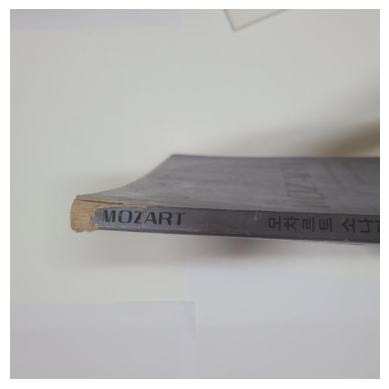

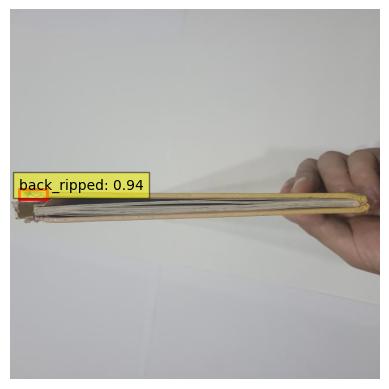

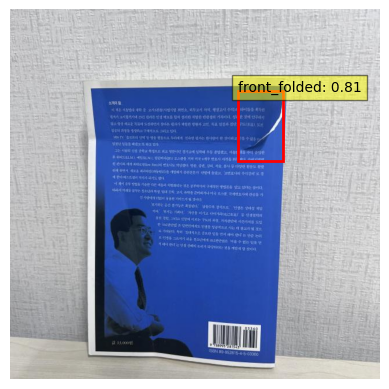

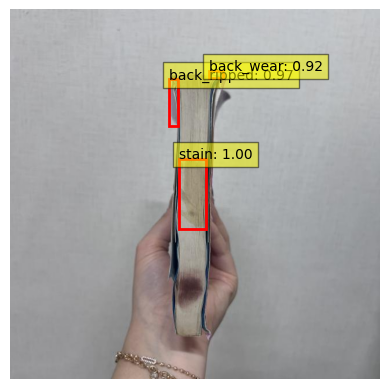

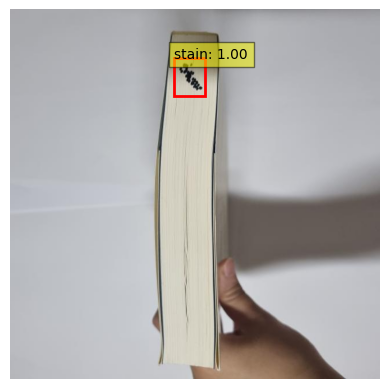

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# 장치 설정 (GPU가 사용 가능하면 CUDA, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Faster R-CNN 모델 로드 및 출력 레이어 수정
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 11  # 클래스 수 (10개 + 배경)
in_features = model.roi_heads.box_predictor.cls_score.in_features

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 가중치 로드 (CPU 환경에서 GPU 모델 매핑)
try:
    model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))
    print("Trained model loaded successfully.")
except FileNotFoundError:
    print("모델 가중치 파일이 없습니다. 사전 훈련된 모델을 사용합니다.")

# 모델을 장치로 이동
model.to(device)
model.eval()

# 라벨 맵핑 함수 정의
def load_label_mapping(annotation_file):
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    categories = coco_data["categories"]
    return {cat["id"]: cat["name"] for cat in categories}

# 경로 설정
valid_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/valid/"
valid_annotation_file = os.path.join(valid_data_path, "_annotations.coco.json")

# 라벨 매핑 로드
label_map = load_label_mapping(valid_annotation_file)
print("Label Mapping:", label_map)

# Custom CocoDetection 클래스 정의
class CustomCocoDetection(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.transform = transform
        with open(annFile, 'r') as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        anns = [ann for ann in self.annotations if ann['image_id'] == img_info['id']]
        boxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# 변환 설정
transform = transforms.Compose([transforms.ToTensor()])

# Validation DataLoader 설정
valid_dataset = CustomCocoDetection(root=valid_data_path, annFile=valid_annotation_file, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=lambda batch: tuple(zip(*batch)))

# 예측 및 시각화 함수 정의
def predict_and_visualize(model, data_loader, device, label_map, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            # 첫 번째 몇 개 이미지에 대해 결과 시각화
            if i < num_images:
                visualize_prediction(images[0], outputs[0], label_map)

def visualize_prediction(image, output, label_map):
    """예측 결과를 시각화합니다."""
    image = F.to_pil_image(image.cpu())
    plt.imshow(image)

    for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        if score > 0.5:  # 신뢰도 50% 이상인 경우만 표시
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(
                plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              fill=False, edgecolor='red', linewidth=2)
            )
            label_name = label_map.get(int(label), "Unknown")
            plt.text(x_min, y_min, f"{label_name}: {score:.2f}",
                     bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Validation 데이터 예측 수행
print("Predicting on validation data...")
predict_and_visualize(model, valid_loader, device, label_map)


Test 데이터셋 predict 하는 코드

Using device: cpu


<ipython-input-19-99589c7e8336>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))


Trained model loaded successfully.
Label Mapping: {0: 'Damaged-Books-auCm-8btb-bpaW', 1: 'back_ripped', 2: 'back_wear', 3: 'front_folded', 4: 'front_ripped', 5: 'front_wear', 6: 'side_ripped', 7: 'side_wear', 8: 'stain', 9: 'wet'}
Predicting on validation data...


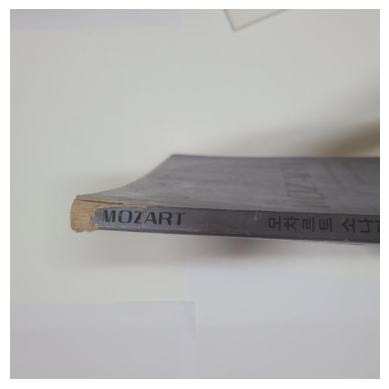

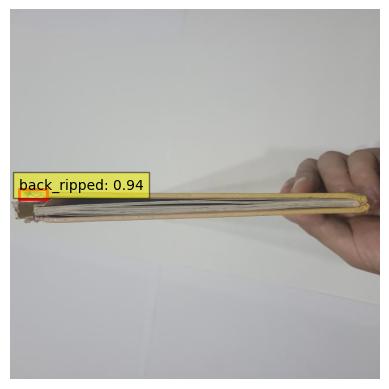

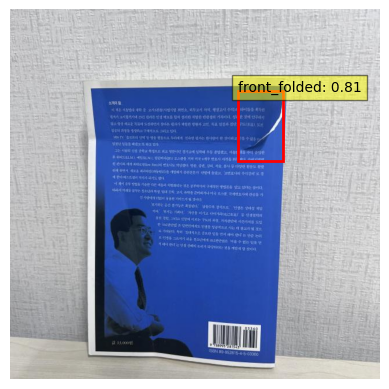

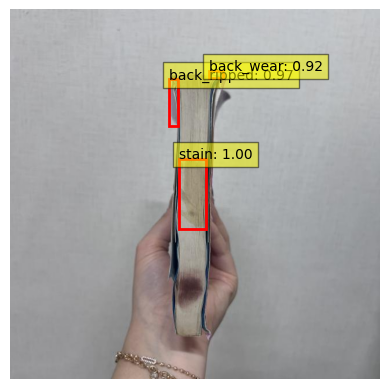

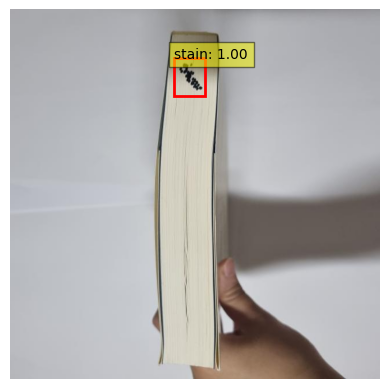

Predicting on test data...


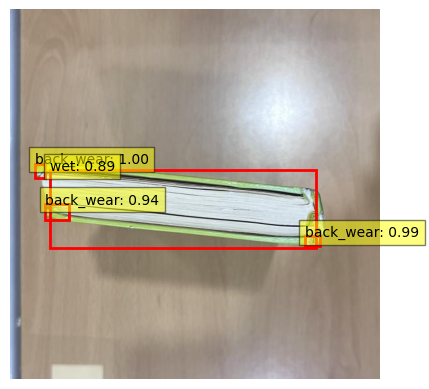

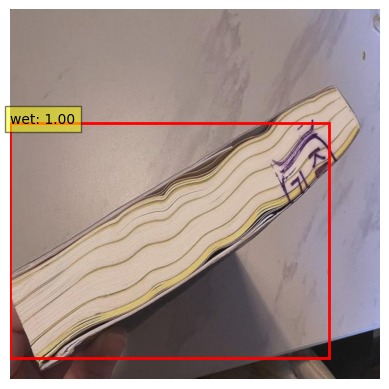

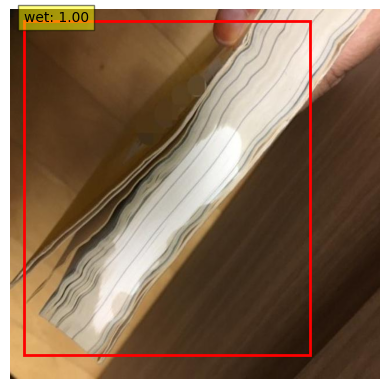

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# 장치 설정 (GPU가 사용 가능하면 CUDA, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Faster R-CNN 모델 로드 및 출력 레이어 수정
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 11  # 클래스 수 (10개 + 배경)
in_features = model.roi_heads.box_predictor.cls_score.in_features

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 가중치 로드 (CPU 환경에서 GPU 모델 매핑)
try:
    model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))
    print("Trained model loaded successfully.")
except FileNotFoundError:
    print("모델 가중치 파일이 없습니다. 사전 훈련된 모델을 사용합니다.")

# 모델을 장치로 이동
model.to(device)
model.eval()

# 라벨 맵핑 함수 정의
def load_label_mapping(annotation_file):
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    categories = coco_data["categories"]
    return {cat["id"]: cat["name"] for cat in categories}

# 경로 설정
valid_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/valid/"
test_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/test/"
valid_annotation_file = os.path.join(valid_data_path, "_annotations.coco.json")
test_annotation_file = os.path.join(test_data_path, "_annotations.coco.json")

# 라벨 매핑 로드
label_map = load_label_mapping(valid_annotation_file)
print("Label Mapping:", label_map)

# Custom CocoDetection 클래스 정의
class CustomCocoDetection(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.transform = transform
        with open(annFile, 'r') as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        anns = [ann for ann in self.annotations if ann['image_id'] == img_info['id']]
        boxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# 변환 설정
transform = transforms.Compose([transforms.ToTensor()])

# Validation 및 Test DataLoader 설정
valid_dataset = CustomCocoDetection(root=valid_data_path, annFile=valid_annotation_file, transform=transform)
test_dataset = CustomCocoDetection(root=test_data_path, annFile=test_annotation_file, transform=transform)

valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=lambda batch: tuple(zip(*batch)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=lambda batch: tuple(zip(*batch)))

# 예측 및 시각화 함수 정의
def predict_and_visualize(model, data_loader, device, label_map, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            # 첫 번째 몇 개 이미지에 대해 결과 시각화
            if i < num_images:
                visualize_prediction(images[0], outputs[0], label_map)

def visualize_prediction(image, output, label_map):
    """예측 결과를 시각화합니다."""
    image = F.to_pil_image(image.cpu())
    plt.imshow(image)

    for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        if score > 0.5:  # 신뢰도 50% 이상인 경우만 표시
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(
                plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              fill=False, edgecolor='red', linewidth=2)
            )
            label_name = label_map.get(int(label), "Unknown")
            plt.text(x_min, y_min, f"{label_name}: {score:.2f}",
                     bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Validation 데이터 예측 수행
print("Predicting on validation data...")
predict_and_visualize(model, valid_loader, device, label_map)

# Test 데이터 예측 수행
print("Predicting on test data...")
predict_and_visualize(model, test_loader, device, label_map)


valid, test 평가

In [ ]:
##valid, test 평가

import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 장치 설정 (GPU가 사용 가능하면 CUDA, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Faster R-CNN 모델 로드 및 출력 레이어 수정
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 11  # 클래스 수 (10개 + 배경)
in_features = model.roi_heads.box_predictor.cls_score.in_features

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 가중치 로드 (CPU 환경에서 GPU 모델 매핑)
try:
    model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))
    print("Trained model loaded successfully.")
except FileNotFoundError:
    print("모델 가중치 파일이 없습니다. 사전 훈련된 모델을 사용합니다.")

# 모델을 장치로 이동
model.to(device)
model.eval()

# 라벨 맵핑 함수 정의
def load_label_mapping(annotation_file):
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    categories = coco_data["categories"]
    return {cat["id"]: cat["name"] for cat in categories}

# 경로 설정
valid_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/valid/"
test_data_path = "/content/drive/MyDrive/NIPA-Google ML/20241014_aug_2/dmg_dup2_orig.v2i.coco-segmentation/test/"
valid_annotation_file = os.path.join(valid_data_path, "_annotations.coco.json")
test_annotation_file = os.path.join(test_data_path, "_annotations.coco.json")

# 라벨 매핑 로드
label_map = load_label_mapping(valid_annotation_file)
print("Label Mapping:", label_map)

# Custom CocoDetection 클래스 정의
class CustomCocoDetection(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.transform = transform
        with open(annFile, 'r') as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        anns = [ann for ann in self.annotations if ann['image_id'] == img_info['id']]
        boxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor(img_info['id'], dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# 변환 설정
transform = transforms.Compose([transforms.ToTensor()])

# Validation 및 Test DataLoader 설정
valid_dataset = CustomCocoDetection(root=valid_data_path, annFile=valid_annotation_file, transform=transform)
test_dataset = CustomCocoDetection(root=test_data_path, annFile=test_annotation_file, transform=transform)

valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=lambda batch: tuple(zip(*batch)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=lambda batch: tuple(zip(*batch)))

# 예측 및 평가 함수 정의
def evaluate_model(model, data_loader, annotation_file, device):
    model.eval()
    coco_gt = COCO(annotation_file)
    results = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]

            for i, output in enumerate(model(images)):
                image_id = targets[i]['image_id'].item()
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    results.append({
                        "image_id": int(image_id),
                        "category_id": int(label),
                        "bbox": [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],
                        "score": float(score)
                    })

    # JSON으로 결과 저장
    with open("results.json", "w") as f:
        json.dump(results, f)

    # COCO 평가 수행
    coco_dt = coco_gt.loadRes("results.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # 성능 지표 출력
    print("\nmAP@[IoU=0.50:0.95]:", coco_eval.stats[0])
    print("Precision (AP) @ IoU=0.50:", coco_eval.stats[1])
    print("Recall (AR) @ maxDets=100:", coco_eval.stats[8])

# 예측 결과 시각화 함수 정의
def predict_and_visualize(model, data_loader, device, label_map, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            if i < num_images:
                visualize_prediction(images[0], outputs[0], label_map)

def visualize_prediction(image, output, label_map):
    image = F.to_pil_image(image.cpu())
    plt.imshow(image)

    for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        if score > 0.5:
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(
                plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              fill=False, edgecolor='red', linewidth=2)
            )
            label_name = label_map.get(int(label), "Unknown")
            plt.text(x_min, y_min, f"{label_name}: {score:.2f}",
                     bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Validation 및 Test 데이터 평가 수행
print("Evaluating on validation data...")
evaluate_model(model, valid_loader, valid_annotation_file, device)

print("Evaluating on test data...")
evaluate_model(model, test_loader, test_annotation_file, device)


Using device: cpu


<ipython-input-2-d0e0083c5eee>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))


Trained model loaded successfully.
Label Mapping: {0: 'Damaged-Books-auCm-8btb-bpaW', 1: 'back_ripped', 2: 'back_wear', 3: 'front_folded', 4: 'front_ripped', 5: 'front_wear', 6: 'side_ripped', 7: 'side_wear', 8: 'stain', 9: 'wet'}
Evaluating on validation data...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10